# Assemble Monocam Images
=============================================

- Creation : Tuesday 2016 June 14th
- Author Sylvie Dagoret-Campagne 
- affiliation : LAL/IN2P3/CNRS

Put together the images from the different amplifiers


## 1) Import package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.3.0


In [2]:
from scipy import stats 
from scipy import ndimage
import os
from datetime import datetime, timedelta

In [3]:
import libMonocamBaseImages           # my tool library written to do that CCD reduction

In [4]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2018-06-21 19:57:23.112116
fits date format for the analysis :  2018-06-21T19:57:23


## 2) Configuration of the detector

In [5]:
NB_OF_CHAN_AMPL=16    # 16 images in each of the fits file

In [11]:
path='.'
object_name='ats_exp_0.5_20180615020051'
basefilename='ats_exp_0.5_20180615020051.fits' # check master bias
filename=os.path.join(path,basefilename)
outputfigfilename='ScienceImageAssemblerInput_img.pdf'
outputfigfilename2='ReorderedImage_'+object_name+'_img.pdf'
outputfigfilename3='SingleImage_'+object_name+'_img.pdf'
outputfigfilename4='RotatedImage_'+object_name+'_img.pdf'

In [7]:

object_name='ats_exp_0.5_20180615020051'

## 4) Read the images

In [12]:
allimages = []
for chan in range(1,NB_OF_CHAN_AMPL+1,1):
    ccd_chan = ccdproc.CCDData.read(filename, hdu=chan,unit="adu") 
    allimages.append(ccd_chan)

INFO: An exception happened while extracting WCS informations from the Header.
KeyError: "No WCS with key ' ' was found in the given header" [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS informations from the Header.
KeyError: "No WCS with key ' ' was found in the given header" [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS informations from the Header.
KeyError: "No WCS with key ' ' was found in the given header" [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS informations from the Header.
KeyError: "No WCS with key ' ' was found in the given header" [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS informations from the Header.
KeyError: "No WCS with key ' ' was found in the given header" [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS informations from the Header.
KeyError: "No WCS with key ' ' was found in the given header" [astropy.nddata.ccddata]
INFO

## 5) Shows the images

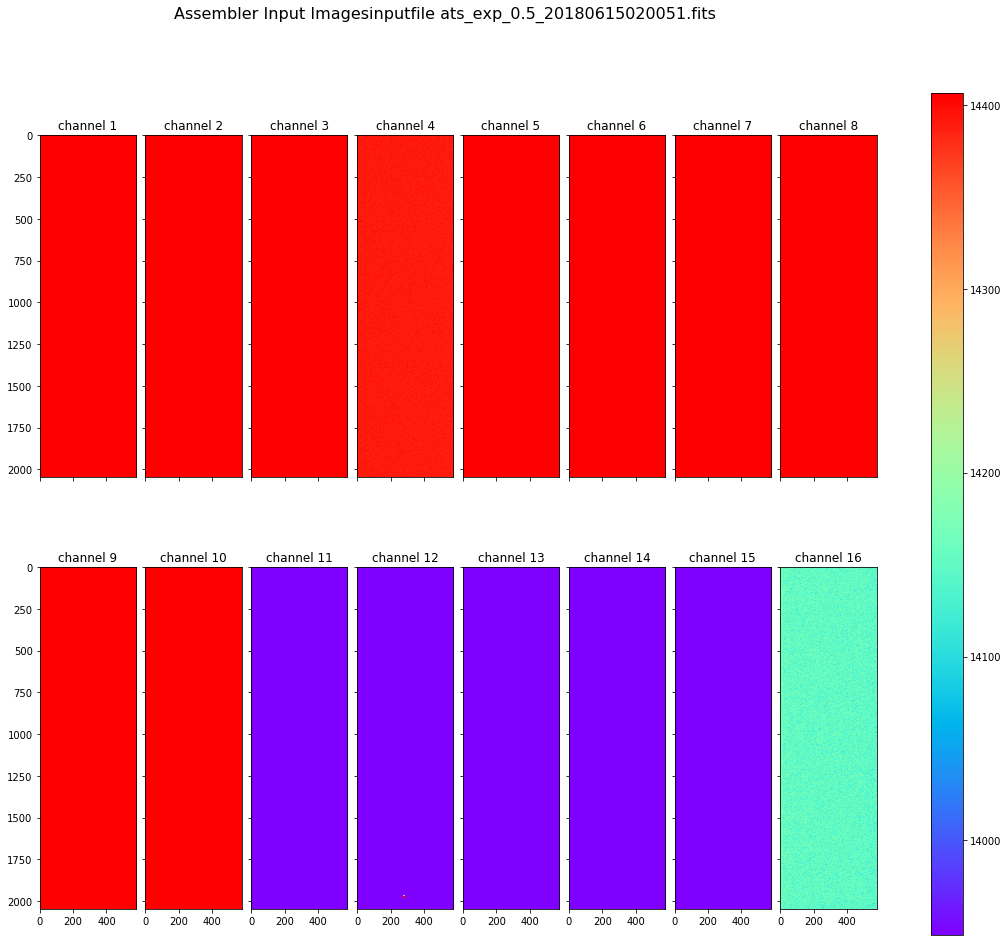

In [13]:
libMonocamBaseImages.ShowImagesSet(allimages,'Assembler Input Images',basefilename,outputfigfilename,nbsig=3)

## 6) Reorder the image

In [17]:
Channel_mapping = [8,7,6,5,4,3,2,1,9,10,11,12,13,14,15,16]
Channel_flipupdo = [False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True]

In [18]:
def ShowCorrectImagesSet(image_list,mapping_chan,flip_chan,obj,figname):
    '''
    Shows the whole set of CCD images
     - inputs argument:
       path : path of the fits file
       filename of the fits file
     - output the images of the whole CCD   
    '''
     
    NX=8 # number of images along the horizontal axis
    NY=2 # number of images along the vertical axis
    MIN=0
    MAX=40.0
    f, axarr = plt.subplots(NY,NX,sharex='col', sharey='row',figsize=(15,15)) # figure organisation
    
    f.subplots_adjust(hspace=0.01,wspace=0.01)

    for index in range(NB_OF_CHAN_AMPL):  
        ix=index%8
        iy=index/8
        goodindex=mapping_chan[index]-1
        if not flip_chan[index]:
            image_data = image_list[goodindex].data[0:2000,:]
        else:
            image_data = np.flipud(np.fliplr(image_list[goodindex].data[0:2000,:]))
        
        im=axarr[iy,ix].imshow(image_data,vmin=MIN,vmax=MAX)  # plot the image
        if ix==0 and iy==0:
            im0=im
        plottitle='channel {}'.format(goodindex+1)
        axarr[iy,ix].set_title(plottitle)
    
    title='Reordered Image for object '+obj
    cax = f.add_axes([0.95, 0.12, 0.03, 0.78]) # [left,bottom,width,height]    
    f.colorbar(im0, cax=cax)
   
    plt.suptitle(title,size=16)
    plt.savefig(figname, bbox_inches='tight')

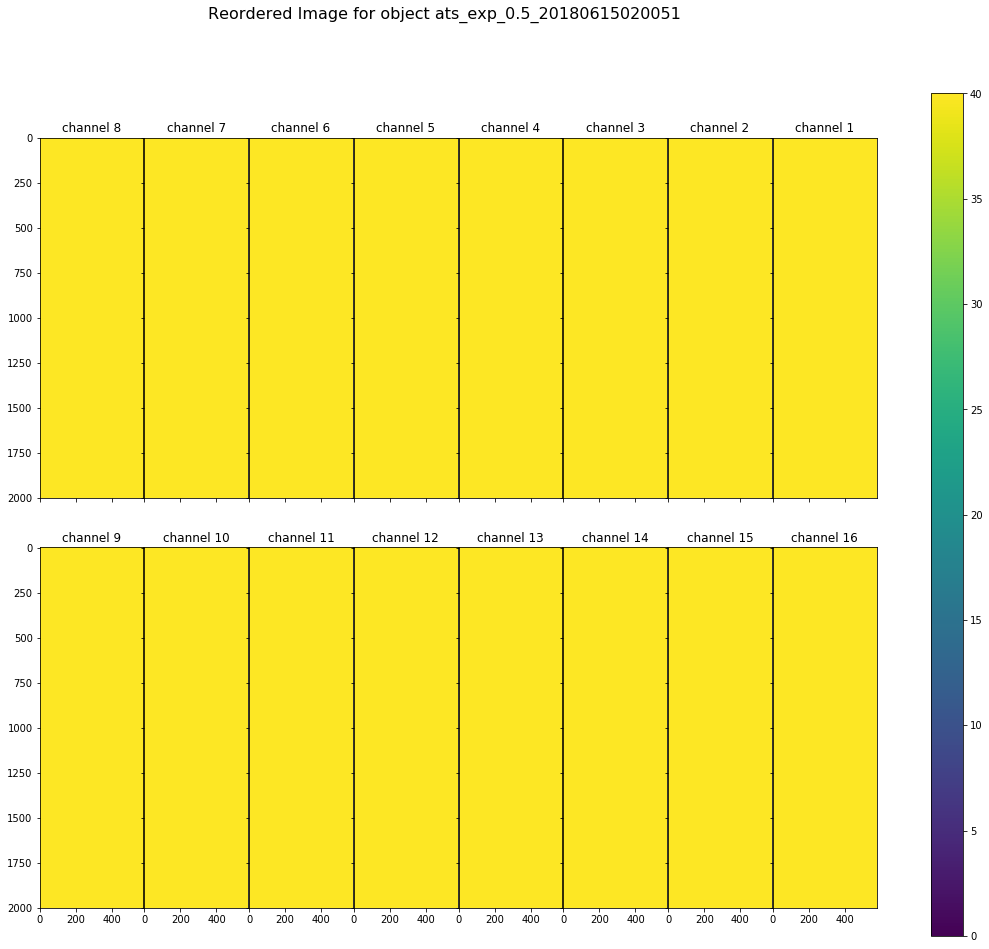

In [19]:
ShowCorrectImagesSet(allimages,Channel_mapping,Channel_flipupdo,object_name,outputfigfilename2)

## 7.) Make a single array

In [20]:
def MakeSingleImage(image_list,mapping_chan,flip_chan):
    '''
     
    '''
         

    for index in range(NB_OF_CHAN_AMPL):  
       
        goodindex=mapping_chan[index]-1
        if not flip_chan[index]:
            image_data = image_list[goodindex].data[0:2000,:]
        else:
            image_data = np.flipud(np.fliplr(image_list[goodindex].data[0:2000,:]))
            
        if index == 0:
            imageup =image_data
        elif index >=1 and index <=7:
            imageup = np.concatenate((imageup,image_data),axis=1)
        elif index ==8 :
            imagedo = image_data
        else:
            imagedo = np.concatenate((imagedo,image_data),axis=1)
            
    full_image=np.concatenate((imageup,imagedo),axis=0)
    return full_image
        
       

In [21]:
concatenatedimage=MakeSingleImage(allimages,Channel_mapping,Channel_flipupdo)

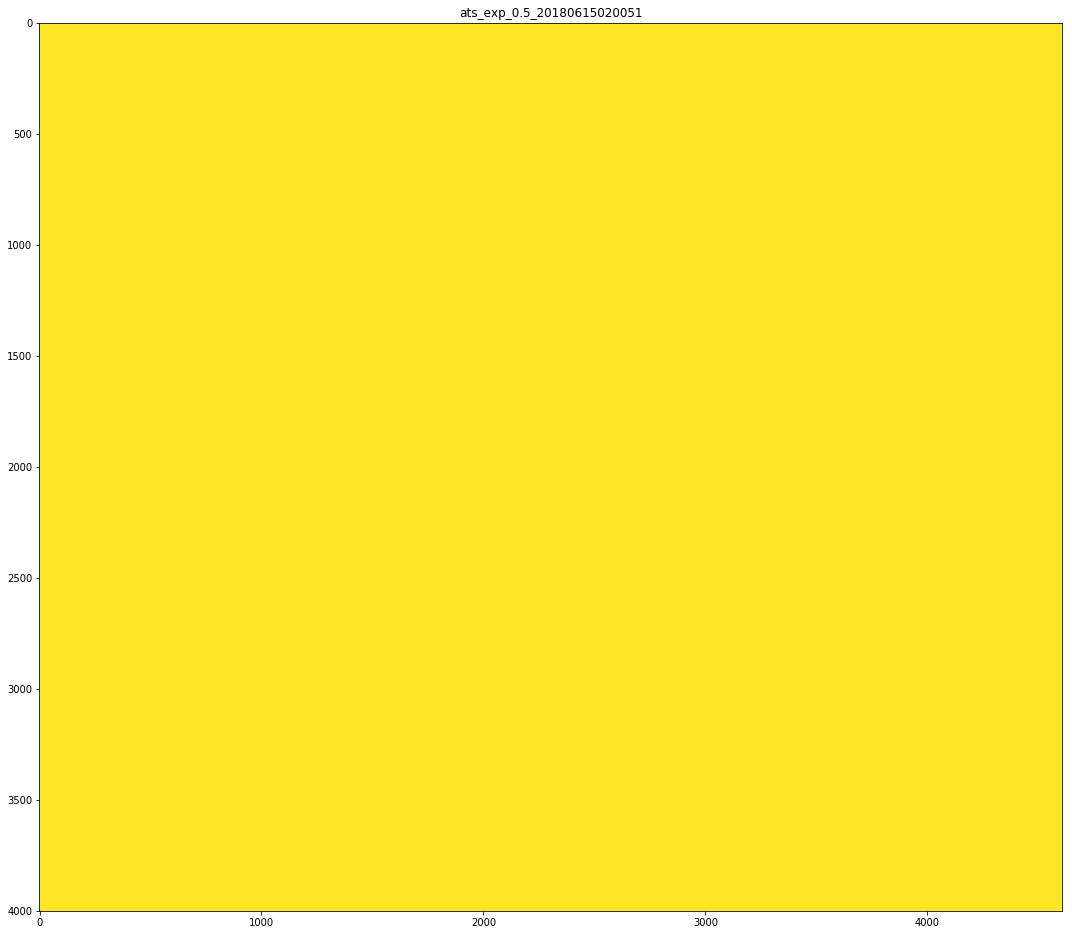

In [23]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(concatenatedimage,vmin=0,vmax=50.)
plt.title(object_name)
plt.tight_layout()
plt.savefig(outputfigfilename3)

## 8.) Image rotation and spectrum region selection

In [24]:
rotated_image=ndimage.interpolation.rotate(concatenatedimage,67.5)

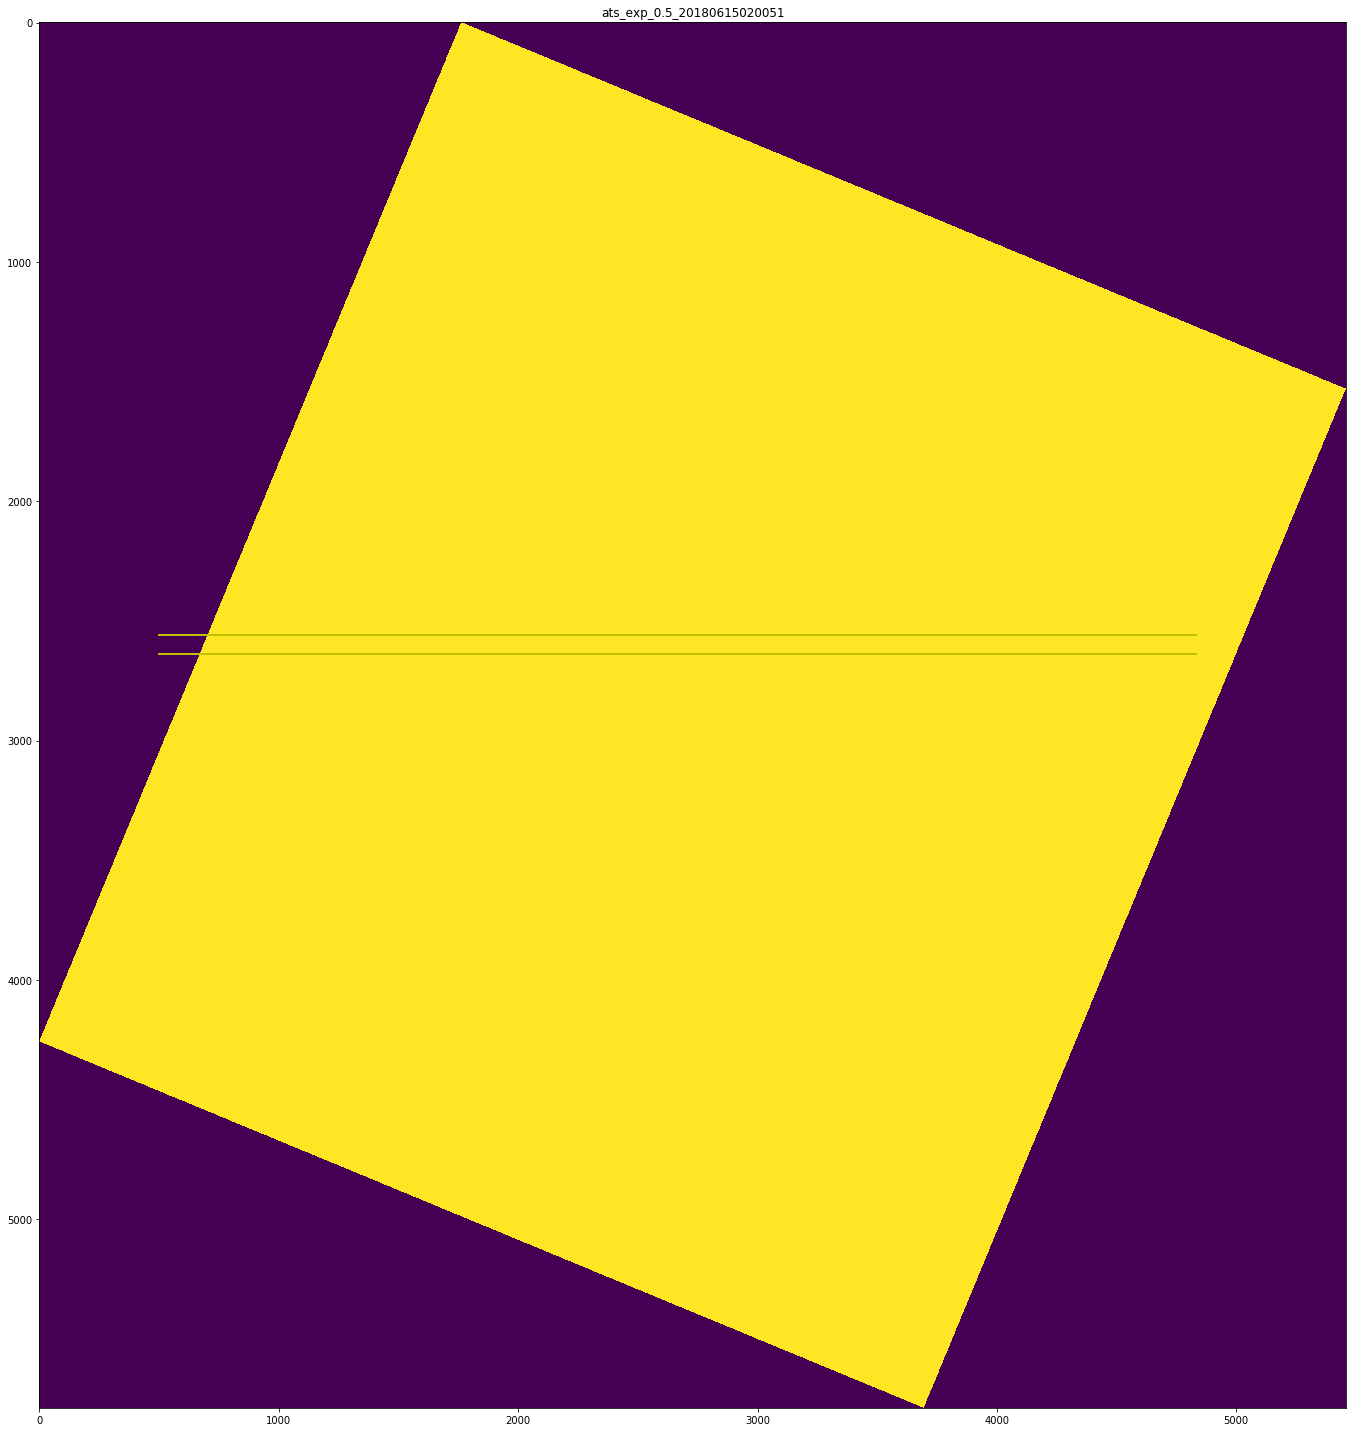

In [25]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(rotated_image,vmin=0,vmax=50.)
ax.plot([500, 4830], [2560, 2560], color='y', linestyle='-', linewidth=2)
ax.plot([500, 4830], [2640, 2640], color='y', linestyle='-', linewidth=2)
plt.title(object_name)
plt.tight_layout()
plt.savefig(outputfigfilename4)

## 9.) Extraction of the spectrum from the image

In [26]:
SpectrumRegion=rotated_image[2560:2640,480:4830]

In [27]:
SpectrumRegion.shape

(80, 4350)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(SpectrumRegion,vmin=0,vmax=50.)

In [ ]:
spectrum=np.sum(SpectrumRegion,axis=0)

In [ ]:
spectrum.shape

## 10.)  Plot the spectrum

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(spectrum)
plt.ylim(0.,2000.)